# ICS 471-Video Classification with a CNN-RNN Architecture

In this session, we will cover how to use RNN for video classification. 

This example demonstrates video classification, an important use-case with
applications in recommendations, security, and so on.
We will be using the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php)
to build our video classifier. The dataset consists of videos categorized into different
actions, like cricket shot, punching, biking, etc. This dataset is commonly used to
build action recognizers, which are an application of video classification.

A video consists of an ordered sequence of frames. Each frame contains *spatial*
information, and the sequence of those frames contains *temporal* information. To model
both of these aspects, we use a hybrid architecture that consists of convolutions
(for spatial processing) as well as recurrent layers (for temporal processing).
Specifically, we'll use a Convolutional Neural Network (CNN) and a Recurrent Neural
Network (RNN) consisting of [GRU layers](https://keras.io/api/layers/recurrent_layers/gru/).
This kind of hybrid architecture is popularly known as a **CNN-RNN**.

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

## Data collection

In order to keep the runtime of this example relatively short, we will be using a
subsampled version of the original UCF101 dataset. You can refer to
[this notebook](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb)
to know how the subsampling was done.

In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

## Setup

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import imageio
import cv2
import os

## Define hyperparameters

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

## Data preparation

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

print(train_df[0:10])  #train_df.sample(10)


Total videos for training: 594
Total videos for testing: 224
                  video_name          tag
0  v_CricketShot_g08_c01.avi  CricketShot
1  v_CricketShot_g08_c02.avi  CricketShot
2  v_CricketShot_g08_c03.avi  CricketShot
3  v_CricketShot_g08_c04.avi  CricketShot
4  v_CricketShot_g08_c05.avi  CricketShot
5  v_CricketShot_g08_c06.avi  CricketShot
6  v_CricketShot_g08_c07.avi  CricketShot
7  v_CricketShot_g09_c01.avi  CricketShot
8  v_CricketShot_g09_c02.avi  CricketShot
9  v_CricketShot_g09_c03.avi  CricketShot


One of the many challenges of training video classifiers is figuring out a way to feed
the videos to a network. [This blog post](https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5)
discusses five such methods. Since a video is an ordered sequence of frames, we could
just extract the frames and put them in a 3D tensor. But the number of frames may differ
from video to video which would prevent us from stacking them into batches
(unless we use padding). As an alternative, we can **save video frames at a fixed
interval until a maximum frame count is reached**. In this example we will do
the following:

1. Capture the frames of a video.
2. Extract frames from the videos until a maximum frame count is reached.
3. In the case, where a video's frame count is lesser than the maximum frame count we
will pad the video with zeros.

Note that this workflow is identical to [problems involving texts sequences](https://developers.google.com/machine-learning/guides/text-classification/). Videos of the UCF101 dataset is [known](https://www.crcv.ucf.edu/papers/UCF101_CRCV-TR-12-01.pdf)
to not contain extreme variations in objects and actions across frames. Because of this,
it may be okay to only consider a few frames for the learning task. But this approach may
not generalize well to other video classification problems. We will be using
[OpenCV's `VideoCapture()` method](https://docs.opencv.org/master/dd/d43/tutorial_py_video_display.html)
to read frames from videos.

In [ ]:
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    videoFrames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            #print(frame.shape)
            
            videoFrames.append(frame)

            if len(videoFrames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(videoFrames)


We can use a pre-trained network to extract meaningful features from the extracted
frames. The [`Keras Applications`](https://keras.io/api/applications/) module provides
a number of state-of-the-art models pre-trained on the [ImageNet-1k dataset](http://image-net.org/).
We will be using the [InceptionV3 model](https://arxiv.org/abs/1512.00567) for this purpose.

In [ ]:

def build_feature_extractor():
    InceptionV3_model = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))

    # preprocess the input
    preprocess_input = keras.applications.inception_v3.preprocess_input(inputs)

    # extract the features from the preprocessed input
    outputs = InceptionV3_model(preprocess_input)

    # form the final model 
    myModel = keras.Model(inputs, outputs, name="feature_extractor")
    
    return myModel


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 0s 0us/step


The labels of the videos are strings. Neural networks do not understand string values,
so they must be converted to some numerical form before they are fed to the model. Here
we will use the [`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer encode the class labels as integers.

In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


Finally, we can put all the pieces together to create our data processing utility.

In [ ]:
def frames_downUpSamples(vidoeFrames, nFramesTarget):
    """ Adjust number of frames (eg 123) to nFramesTarget (eg 79)
    works also if originally less frames then nFramesTarget
    """
    nSamples, _, _, _ = vidoeFrames.shape
    if nSamples == nFramesTarget: return vidoeFrames

    # down/upsample the list of frames
    fraction = nSamples / nFramesTarget
    index = [int(fraction * i) for i in range(nFramesTarget)]
    frames = [vidoeFrames[i,:,:,:] for i in index]

    return np.array(frames)

def prepare_all_videos(dataFile, root_dir):
    num_samples = len(dataFile)
    # get video paths
    video_paths = dataFile["video_name"].values.tolist()
    
    # convert labels into numerical values
    labels = dataFile["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # Iterate through all videos and do the following:
    allVideosFeatures = []
    # 1) For each video.
    for idx, path in enumerate(video_paths):
        # 2) Gather all its frames 
        frames = load_video(os.path.join(root_dir, path))

        # 3) down/up sample the number of frames to MAX_SEQ_LENGTH
        videoFrames = frames_downUpSamples(frames, MAX_SEQ_LENGTH)
        #print(videoFeatures.shape)

        # 4) Extract the CNN features from all video frames
        videoFeatures = feature_extractor.predict(videoFrames, verbose=0)
        #print(videoFeatures.shape)

        # 5) add the extracted features of each video to allVideosFeatures list
        allVideosFeatures.append(videoFeatures.squeeze())

    return np.array(allVideosFeatures), labels

# we will process only 15 vidoes for training and 5 vidoes for testing
train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data.shape}")


Frame features in train set: (594, 20, 2048)


The above code block will take ~20 minutes to execute depending on the machine it's being
executed.

## The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like `GRU`.

In [ ]:
from keras.layers import GRU 
def create_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))


    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model(frame_features_input, output)
    
    adamOptimizer = keras.optimizers.Adam(lr = 1e-4)
    rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer=adamOptimizer, metrics=["accuracy"])

    return rnn_model


# Utility for running experiments.
def run_experiment():
  # First, we will create callbacks to be used for saving the models and early stopping
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1 )
    earlyStopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)       
   
    # create the RNN model
    seq_model = create_sequence_model()

    # start the training
    history = seq_model.fit(
        train_data,
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint, earlyStopper])

    # use the best model saved during training process for testing
    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate(test_data, test_labels)
    
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 8/13 [=================>............] - ETA: 0s - loss: 1.6380 - accuracy: 0.2227 
Epoch 1: val_loss improved from inf to 1.75776, saving model to /tmp/video_classifier
13/13 [==============================] - 4s 63ms/step - loss: 1.6028 - accuracy: 0.2313 - val_loss: 1.7578 - val_accuracy: 0.0447
Epoch 2/10
 7/13 [===============>..............] - ETA: 0s - loss: 1.4733 - accuracy: 0.3661
Epoch 2: val_loss did not improve from 1.75776
13/13 [==============================] - 0s 12ms/step - loss: 1.4473 - accuracy: 0.4048 - val_loss: 1.8872 - val_accuracy: 0.0112
Epoch 3/10
 8/13 [=================>............] - ETA: 0s - loss: 1.3733 - accuracy: 0.4727
Epoch 3: val_loss did not improve from 1.75776
13/13 [==============================] - 0s 14ms/step - loss: 1.3419 - accuracy: 0.5373 - val_loss: 1.8680 - val_accuracy: 0.0168
Epoch 4/10
 8/13 [=================>............] - ETA: 0s - loss: 1.2892 - accuracy: 0.5508
Epoch 4: val_loss did not improve from 1.75776
13/13 [==========

**Note**: To keep the runtime of this example relatively short, we just used a few
training examples. This number of training examples is low with respect to the sequence
model being used that has 99,909 trainable parameters. You are encouraged to sample more
data from the UCF101 dataset using [the notebook](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb) mentioned above and train the same model.

## Inference (testing)

Test video path: v_CricketShot_g06_c04.avi
(20, 224, 224, 3)
  CricketShot: 46.13%
  Punch: 18.76%
  TennisSwing: 15.61%
  ShavingBeard:  9.96%
  PlayingCello:  9.53%



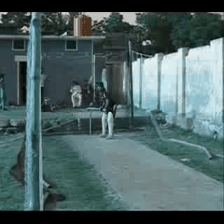

In [ ]:

def prepare_single_video(frames):
    # Extract the features from the video frames
    frame_features = feature_extractor.predict(frames)
    return np.asarray(frame_features)


def sequence_prediction(path):

    class_vocab = label_processor.get_vocabulary()
    # load video frames
    frames = load_video(os.path.join("test", path))

    # down/up sample video frames
    videoFrames = frames_downUpSamples(frames, MAX_SEQ_LENGTH)
    AllVidoesFeatures = []
    print(videoFrames.shape)

    # Extract the features from the video frames
    videoFeatures = feature_extractor.predict(videoFrames, verbose=0)
    AllVidoesFeatures.append(videoFeatures)
    
    # Do prediction
    probabilities = sequence_model.predict(np.array(AllVidoesFeatures))[0]

    # Display the result as probilities for each class

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
        
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

## Aknowledgment
This lab is based on the "Training a video classifier with transfer learning and a recurrent model on the UCF101 dataset." by Sayak Paul.
 